<a href="https://colab.research.google.com/github/SquareGraph/TwitterSentimentAnalysis/blob/main/Sentiment_Analysis_Model_for_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment analysis for crypto twitter feed

Model that will later be served through the server in real-time, for purpose of monitoring certain events and general mood in the given industry.

1. Let's start with uploading kaggle.json to easily download their datasets.
2. We will create three different datasets, on which we will train the algorithm:
<br>a) https://www.kaggle.com/datasets/kazanova/sentiment140*
<br>b) https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news
<br>c https://www.kaggle.com/shashank1558/preprocessed-twitter-tweets

3. Then we will create a Double-stacked LSTM model with pre-trianed Universal Sentence Encoder embeddings, and train this model on each of the datasets. We will evaluate each of the models and compare them (mix of classification metrics). 

4. Fourth step is to get live tweets from a certain topic, on which we can make a real predictions, about the sentiment, and randomly check how it performs. We will use Tweepy and Twitter API for this. We will make predictions on a three topics per each of the models:
<br>a) We will pick ten tweets from each of the topics.
<br>b) The following topics are: Elon Musk, Bitcoin, English Premier League
<br>c) Make some sentiment classification on our best performing model, and print out some sample sentences.

*This dataset consists only of two labels. But it's the biggest and most interesting. We may use sigmoid outputs to calculate the level of sentiment (how positive or how negative they are), or in other words use logits to bin them in three groups, to compare the results with all the other models when we will be predicting!

# 1. Let's start from building datasets. 
We have to upload kaggle.json to the notebook, to download the datasets.

In [1]:
import os
from google.colab import files, drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
!mkdir ~/.kaggle

In [3]:
!cp /content/gdrive/MyDrive/CREDENTIALS/kaggle.json  ~/.kaggle/

In [4]:
!chmod 600 /root/.kaggle/kaggle.json

## 1a. It's time for a Sentiment 140 dataset.

In [5]:
!kaggle datasets download -d kazanova/sentiment140

 89% 72.0M/80.9M [00:02<00:00, 45.3MB/s]
100% 80.9M/80.9M [00:02<00:00, 31.2MB/s]


In [6]:
!unzip /content/sentiment140.zip

Archive:  /content/sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [7]:
#let's create dataframe, to take a look on this dataset!

import pandas as pd

headers=["sentiment","tweet_id", "date", "QUERY", "username", "text"]

s140_df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding='ISO-8859-1', names=headers) #standard utf-8 encoding provided an error. ISO is working.

s140_df.head() 

,sentiment,tweet_id,date,QUERY,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
# We are interested in only two columns - sentiment and text. We will create dataframe consisting of those two series.

sentiment_140_df = s140_df[["sentiment","text"]]

In [9]:
print(f"The shape of a df is: {sentiment_140_df.shape}, "
f"and the unique values of Sentiment series are: {sentiment_140_df.sentiment.unique()[0],sentiment_140_df.sentiment.unique()[1]}"
f"\nAnd they are distribiuted as follows: \n{sentiment_140_df.sentiment.value_counts()}")

The shape of a df is: (1600000, 2), and the unique values of Sentiment series are: (0, 4)
And they are distribiuted as follows: 
0    800000
4    800000
Name: sentiment, dtype: int64


In [10]:
# from the documentation we know that 4 means positive, and 0's are negatives. We want to turn those values into binary classification problem

sentiment_140_df.sentiment.replace(4,1, inplace=True)
sentiment_140_df.sentiment.value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


0    800000
1    800000
Name: sentiment, dtype: int64

In [11]:
# and also we want to shuffle rows, to have a kind of an equal distribution of all the samples when we will divide them into train and test splits
sentiment_140_df = sentiment_140_df.sample(frac=1)
# and it's quite big, so let's take a 2% of a data only, would train for an hours.
# 2% is around 3200 records

sentiment_140_df_two_percent = sentiment_140_df[:3200]

In [12]:
from sklearn.model_selection import train_test_split

X_train140, X_test140, y_train140, y_test140 = train_test_split(sentiment_140_df_two_percent.text.to_numpy(), 
                                                                sentiment_140_df_two_percent.sentiment.to_numpy(), test_size=0.2)

In [13]:
X_train140.shape, X_test140.shape, y_train140.shape, y_test140.shape # it looks like shapes matches each other, so it's time to create tf tensors

((2560,), (640,), (2560,), (640,))

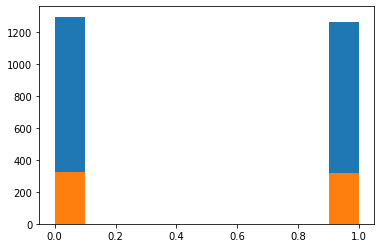

In [14]:
#And check the distribution of labels per each dataset
import matplotlib.pyplot as plt

plt.hist(y_train140), plt.hist(y_test140) #blue is train dataset, orange is test
plt.show()

In [15]:
import tensorflow as tf

#Simple dataset from slices, later will enhance all of the datasets --
#With a function for prefetching, cacheing and autotuing

train_140 = tf.data.Dataset.from_tensor_slices((X_train140,y_train140))
test_140 = tf.data.Dataset.from_tensor_slices((X_test140,y_test140)) 

## 2b. Now for the Sentiment Analysis for the Financial Data

In [16]:
!kaggle datasets download -d ankurzing/sentiment-analysis-for-financial-news

  0% 0.00/903k [00:00<?, ?B/s]
100% 903k/903k [00:00<00:00, 151MB/s]


In [17]:
!unzip /content/sentiment-analysis-for-financial-news.zip

Archive:  /content/sentiment-analysis-for-financial-news.zip
  inflating: FinancialPhraseBank/License.txt  
  inflating: FinancialPhraseBank/README.txt  
  inflating: FinancialPhraseBank/Sentences_50Agree.txt  
  inflating: FinancialPhraseBank/Sentences_66Agree.txt  
  inflating: FinancialPhraseBank/Sentences_75Agree.txt  
  inflating: FinancialPhraseBank/Sentences_AllAgree.txt  
  inflating: all-data.csv            


In [18]:
# according to the readme file we have a four different datasets, 
# depending on the way labeling was made. We will continiue with "All Agree" file.

with open("/content/FinancialPhraseBank/Sentences_AllAgree.txt", "r", errors="replace", encoding='ISO-8859-1') as f:
    text = f.readlines()

In [19]:
text[0:3], text[-3:], len(text)  

# here we have the labels as a last word in a list. 
#Also we find that there are 2264 lines only, so kind'a small set.

(['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral\n',
  "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .@positive\n",
  'In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .@positive\n'],
 ['LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .@negative\n',
  'Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn .@negative\n',
  'Sales in Finland decreased by 10.5 % in January , while sales outside Finland dropped by 17 % .@negative\n'],
 2264)

In [20]:
label = text[0].split().pop(-1)

In [21]:
def extract_label(x):
    return x.split("@").pop(-1)

def extract_text(x):
    return x.split("@")[0]

In [22]:
labels = [extract_label(sentence) for sentence in text]
sentences = [extract_text(sentence) for sentence in text]

In [23]:
len(labels) == len(sentences) # check if we have

True

In [24]:
sentences[0], labels[0] # sample sentence and label

('According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
 'neutral\n')

In [25]:
text[0] # the same sentence from the text block

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral\n'

In [26]:
# Let's check all the labels type we have.
import numpy as np

labels_np = np.asarray(labels)
class_names = np.unique(labels_np)
class_names # three labels, and we want to turn them into vectors

array(['negative\n', 'neutral\n', 'positive\n'], dtype='<U9')

In [27]:
int_labels = np.arange(0,3,1) # first we want to create an array of integer labels coresponding to the class names
mapping_dict = dict(zip(class_names, int_labels)) # dict from zip
vectorized_labels = np.vectorize(mapping_dict.get)(labels) # numpy vectorize with a dict.get

In [28]:
mapping_dict

{'negative\n': 0, 'neutral\n': 1, 'positive\n': 2}

In [29]:
vectorized_labels[:10], labels[:10] # compare if everything is correct. Looks fine.

(array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 ['neutral\n',
  'positive\n',
  'positive\n',
  'positive\n',
  'positive\n',
  'positive\n',
  'positive\n',
  'positive\n',
  'positive\n',
  'positive\n'])

In [30]:
# let's call train_test_split with some additional shuffling

X_train_fin, X_test_fin, y_train_fin, y_test_fin = train_test_split(sentences, 
                                                                    vectorized_labels, 
                                                                    test_size=0.2, 
                                                                    shuffle=True)

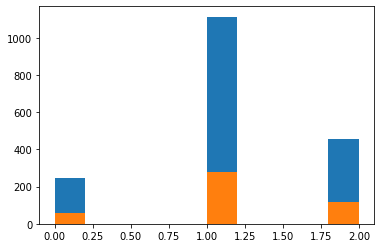

In [31]:
plt.hist(y_train_fin), plt.hist(y_test_fin) #blue is train dataset, orange is test
plt.show() # little bit unbalanced, but gaussian like.

In [32]:
#Let's make a function that will do all above in a single line, maybe other datasets are more balanced. Let's find out.

def extract_data_from_file(filepath:str):

    """Function that takes out text and labels from txt files from the dataset 
    FinancialPhraseBank, and returns tuple of sklearn train_test_split 
    and an array of class_names, and plots an matplotlib  figure with a 
    distribution of labels. Returned labels are already vectorized."""

    # Open file with a proper encoding
    with open(filepath, "r", errors="replace", encoding='ISO-8859-1') as f:
        text = f.readlines()

    #Extract sentences and labels
    labels = [extract_label(sentence) for sentence in text]

    sentences = [extract_text(sentence) for sentence in text]


    
    labels_np = np.asarray(labels) #convert to numpy
    class_names = np.unique(labels_np) #create class_names

    int_labels = np.arange(0,class_names.shape[0],1) # create a vector corresponding to the class names
    mapping_dict = dict(zip(class_names, int_labels)) # dict from zip
    vectorized_labels = np.vectorize(mapping_dict.get)(labels) # numpy vectorize with a dict.get to map

    #splitting into train and test data
    X_train_fin, X_test_fin, y_train_fin, y_test_fin = train_test_split(sentences, 
                                                                    vectorized_labels, 
                                                                    test_size=0.2, 
                                                                    shuffle=True)
    
    #Plot the distribution - > blue is train dataset, orange is test
    plt.hist(y_train_fin), plt.hist(y_test_fin) 
    plt.show()  

    return (X_train_fin, X_test_fin, y_train_fin, y_test_fin), class_names

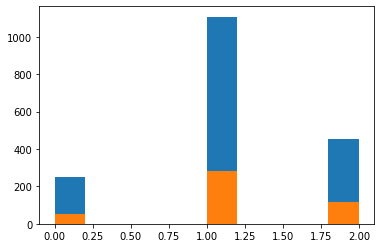

In [33]:
fin_data_all, class_names_all = extract_data_from_file("/content/FinancialPhraseBank/Sentences_AllAgree.txt")

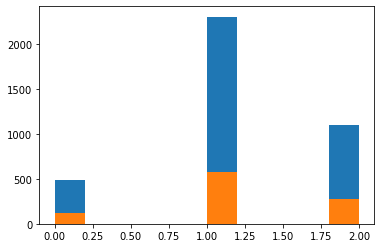

In [34]:
fin_data_50, class_names_50 = extract_data_from_file("/content/FinancialPhraseBank/Sentences_50Agree.txt")

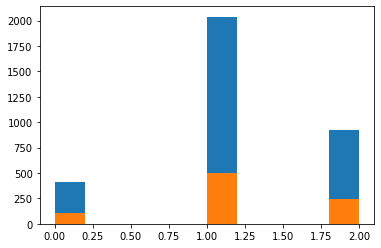

In [35]:
fin_data_66, class_names_66 = extract_data_from_file("/content/FinancialPhraseBank/Sentences_66Agree.txt")

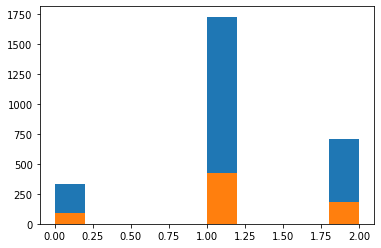

In [36]:
fin_data_75, class_names_75 = extract_data_from_file("/content/FinancialPhraseBank/Sentences_75Agree.txt")

In [37]:
fin_data_50[2].shape, fin_data_50[3].shape

((3876,), (970,))

In [38]:
#All the data are imbalanced, but in the same way. 
#We will continue with the data with most samples - which is 50Agree dataset.
#Time for turning them into tensors!

train_fin = tf.data.Dataset.from_tensor_slices((fin_data_50[0],fin_data_50[2]))
test_fin = tf.data.Dataset.from_tensor_slices((fin_data_50[1],fin_data_50[3]))

## 2c. Preprocessed twitter tweets!

In [39]:
!kaggle datasets download -d shashank1558/preprocessed-twitter-tweets

  0% 0.00/74.8k [00:00<?, ?B/s]
100% 74.8k/74.8k [00:00<00:00, 56.1MB/s]


In [40]:
#For extracting the last zipfile, we will use zipFile this time to keep control over directories much easier

from zipfile import ZipFile

with ZipFile('/content/preprocessed-twitter-tweets.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall("/content/preprocessed_tweets/")


In [41]:
# this time we have different sentiment in different files, also three categories
# firstly, let's take a look at those files.

negative = pd.read_csv("/content/preprocessed_tweets/processedNegative.csv").T.reset_index() #some transformations for easy reading
neutral = pd.read_csv("/content/preprocessed_tweets/processedNeutral.csv").T.reset_index()
positive = pd.read_csv("/content/preprocessed_tweets/processedPositive.csv").T.reset_index()

In [42]:
negative.shape, neutral.shape, positive.shape, # looks like a normal distribution, but much more balanced then previous financial data

((1117, 1), (1570, 1), (1186, 1))

In [43]:
negative.head()

,index
0,How unhappy some dogs like it though
1,talking to my over driver about where I'm goin...
2,Does anybody know if the Rand's likely to fall...
3,I miss going to gigs in Liverpool unhappy
4,There isnt a new Riverdale tonight ? unhappy


In [44]:
positive.head()

,index
0,An inspiration in all aspects: Fashion
1,fitness
2,beauty and personality. :)KISSES TheFashionIcon
3,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...
4,Beautiful album from the greatest unsung guit...


In [45]:
# now we wanna add a sentiment label to each of the dataframes, and concatanate them
# we'll keep the same order as with previous Dataset

negative["sentiment"] = 0
neutral["sentiment"] = 1
positive["sentiment"] = 2

dataset_twitter = pd.concat([negative, neutral, positive])
dataset_twitter.rename(columns={"index":"text"}, inplace=True) # because index may be mistaken later on

In [46]:
dataset_twitter = dataset_twitter.sample(frac=1) # shuffle a bit

In [47]:
X_train_twitter, X_test_twitter, y_train_twitter, y_test_twitter = train_test_split(dataset_twitter.text.to_numpy(), 
                 dataset_twitter.sentiment.to_numpy(),
                 test_size=0.2,
                 shuffle=True)

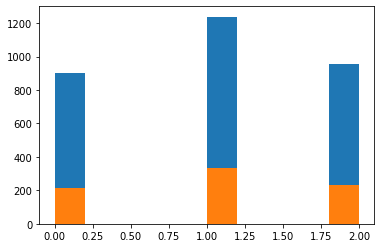

In [48]:
plt.hist(y_train_twitter), plt.hist(y_test_twitter) #Check the final distribution of labels
plt.show()

In [49]:
# And now into tensors

train_twitter = tf.data.Dataset.from_tensor_slices((X_train_twitter, y_train_twitter))
test_twitter = tf.data.Dataset.from_tensor_slices((X_test_twitter, y_test_twitter))

### Extras - preprocess all the datasets. 
We will do prefetch, batch and autotune to make those sets works faster with TF. We will also prepare different batch size versions.

In [50]:
def preprocess(dataset, batch_size):
    return dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [51]:
# apply above function

#FIRST DATASET - Sentiment 140
train_140_32 = preprocess(train_140, 32)
test_140_32 = preprocess(test_140, 32)


#SECOND DATASET - FinancialPhraseBank 50Agree
train_fin_32 = preprocess(train_fin, 32)
test_fin_32 = preprocess(test_fin, 32)


#THIRD DATASET - Preprocessed Tweets
train_tw_32 = preprocess(train_twitter, 32)
test_tw_32 = preprocess(test_twitter, 32)

#3. Time to build a model.

I tested a couple of models for a similar cases, and will implement one that was working best so far.

In [52]:
from tensorflow.keras import layers
import tensorflow_hub as hub

# we will download a KerasLayer UniversalSentenceEncoder
use = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                     input_shape=[], dtype=tf.string, trainable=False, name="USE")


In [53]:
#We will need two different models, so we will functionize building them, according to categorical or binary classification
def build_model(batch_szie, name, lstm_node_1=128, 
                  lstm_node_2=128, 
                  dense_nodes=128, softmax=True, num_classes=3):

    """Functional API model, where you can define if you want softmax or sigmoid activation for the final layer.
        Optimizer: Adam,
        Loss: Depending SparseCategoricalCrossEntropy or BinaryCrossEntropy
        Metrics: Accuracy, but we will evaluate them later on with a specific function

    Returns: compiled model
    """

    inputs = layers.Input((), batch_szie, dtype=tf.string) #One sentence at a time
    embeddings = use(inputs) #pretrained embeddings through Universal Sentence Encoder

    #reshape embeddings for LSTM
 
    #LSTM tower
    lstm_1 = layers.LSTM(lstm_node_1, name="lstm_1", return_sequences=True)(tf.expand_dims(embeddings, 1)) #here wehave to expand dims according to lstm layer specification -> [Batch, timesteps(additional dimension), feature]
    lstm_2 = layers.LSTM(lstm_node_2, name="lstm_2")(lstm_1)

    #Dense layer
    dense = layers.Dense(dense_nodes, activation="relu")(lstm_2)

    #output layer with a switch
    outputs = layers.Dense(num_classes, activation="softmax")(dense) if softmax else layers.Dense(1, activation="sigmoid")(dense)

    #Build a model
    model = tf.keras.Model(inputs, outputs, name=name)

    #define a loss function according to a switch
    loss = tf.keras.losses.SparseCategoricalCrossentropy() if softmax else tf.keras.losses.BinaryCrossentropy()
    model.compile(loss=loss, 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics=['accuracy'])
    
    return model

In [54]:
model_140_32 = build_model(32, "140_32")

In [55]:
model_140_32.summary() # as everything is working fine, we will build every other model

Model: "140_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32,)]                   0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 1, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            328192    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 3)                 387  

In [56]:
# we are compiling a model for every batch size for each of the datasets

model_140_32 = build_model(32, "140_32", softmax=False) # compiling and building once again to keep it nice and clean
model_fin_32 = build_model(32, "fin_32")
model_twt_32 = build_model(32, "twt_32")

In [57]:
model_fin_32.summary()

Model: "fin_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(32,)]                   0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 tf.expand_dims_2 (TFOpLambd  (None, 1, 512)           0         
 a)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            328192    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                            

In [58]:
# And now we want to make a function that will train each model on each of the datasets

def train(model, ds, val_ds, epochs=5, with_callbacks=True, patience=4):
    """This function will fit the model on each of a datasets, 
    on a specific amount of epochs, saving everything up into dictionary"""

    #Let's start from creating a callbacks according to the function arguments

    if with_callbacks:
        checkpoint_save = tf.keras.callbacks.ModelCheckpoint(f"/content/model_checkpoints/{model.name}", 
                                                            save_best_only=True)
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=patience)
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          restore_best_weights=True, patience=patience+1)

        callbacks = [checkpoint_save, reduce_lr, early_stopping]
    else:
        callbacks = []

    # now let's train the model

    # dictionary for the outputs of training
    models = {}

    #training

    history_model = model.fit(ds, epochs=epochs, 
                                    validation_data=val_ds, callbacks=callbacks)
            
    models[f"history_{model.name}"] = history_model
    models[f"model_{model.name}"] = model

    return models



In [59]:
trained_140_32 = train(model_140_32, train_140_32, test_140_32)

Epoch 1/5
80/80 [==============================] - ETA: 0s - loss: 0.6106 - accuracy: 0.6875

80/80 [==============================] - 32s 254ms/step - loss: 0.6106 - accuracy: 0.6875 - val_loss: 0.5311 - val_accuracy: 0.7359 - lr: 0.0010
Epoch 2/5
76/80 [===========================>..] - ETA: 0s - loss: 0.4795 - accuracy: 0.7759

80/80 [==============================] - 17s 220ms/step - loss: 0.4763 - accuracy: 0.7766 - val_loss: 0.5210 - val_accuracy: 0.7453 - lr: 0.0010
Epoch 3/5
80/80 [==============================] - 1s 14ms/step - loss: 0.4564 - accuracy: 0.7973 - val_loss: 0.5269 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 4/5
80/80 [==============================] - 1s 14ms/step - loss: 0.4448 - accuracy: 0.8016 - val_loss: 0.5311 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 5/5
80/80 [==============================] - 1s 14ms/step - loss: 0.4341 - accuracy: 0.8070 - val_loss: 0.5350 - val_accuracy: 0.7406 - lr: 0.0010


In [60]:
trained_fin_32 = train(model_fin_32, train_fin_32, test_fin_32)

Epoch 1/5
119/122 [============================>.] - ETA: 0s - loss: 0.8443 - accuracy: 0.6253

122/122 [==============================] - 23s 162ms/step - loss: 0.8401 - accuracy: 0.6275 - val_loss: 0.7055 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 2/5
118/122 [============================>.] - ETA: 0s - loss: 0.6458 - accuracy: 0.7206

122/122 [==============================] - 18s 151ms/step - loss: 0.6440 - accuracy: 0.7221 - val_loss: 0.6194 - val_accuracy: 0.7340 - lr: 0.0010
Epoch 3/5
119/122 [============================>.] - ETA: 0s - loss: 0.5854 - accuracy: 0.7466

122/122 [==============================] - 19s 156ms/step - loss: 0.5850 - accuracy: 0.7472 - val_loss: 0.6055 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 4/5
119/122 [============================>.] - ETA: 0s - loss: 0.5635 - accuracy: 0.7558

122/122 [==============================] - 18s 151ms/step - loss: 0.5633 - accuracy: 0.7562 - val_loss: 0.6025 - val_accuracy: 0.7340 - lr: 0.0010
Epoch 5/5
122/122 [==============================] - 2s 14ms/step - loss: 0.5476 - accuracy: 0.7681 - val_loss: 0.6026 - val_accuracy: 0.7340 - lr: 0.0010


In [61]:
trained_twt_32 = train(model_twt_32, train_tw_32, test_tw_32)

Epoch 1/5
96/97 [============================>.] - ETA: 0s - loss: 0.6059 - accuracy: 0.7992

97/97 [==============================] - 23s 195ms/step - loss: 0.6036 - accuracy: 0.7995 - val_loss: 0.2798 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 2/5
95/97 [============================>.] - ETA: 0s - loss: 0.2544 - accuracy: 0.9046

97/97 [==============================] - 18s 188ms/step - loss: 0.2547 - accuracy: 0.9038 - val_loss: 0.2724 - val_accuracy: 0.8916 - lr: 0.0010
Epoch 3/5
97/97 [==============================] - 1s 13ms/step - loss: 0.2215 - accuracy: 0.9161 - val_loss: 0.2801 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 4/5
97/97 [==============================] - 1s 13ms/step - loss: 0.2007 - accuracy: 0.9261 - val_loss: 0.2886 - val_accuracy: 0.8942 - lr: 0.0010
Epoch 5/5
97/97 [==============================] - 1s 13ms/step - loss: 0.1844 - accuracy: 0.9335 - val_loss: 0.2987 - val_accuracy: 0.8929 - lr: 0.0010


## Evaluate models on best only checkpoints

In [62]:
best_140 = tf.keras.models.load_model("/content/model_checkpoints/140_32", compile=True)
best_fin = tf.keras.models.load_model("/content/model_checkpoints/fin_32", compile=True)
best_twt = tf.keras.models.load_model("/content/model_checkpoints/twt_32", compile=True)

In [63]:
evaluated_140 = best_140.evaluate(test_140_32)
evaluated_fin = best_fin.evaluate(test_fin_32)
evaluated_twt = best_twt.evaluate(test_tw_32)

25/25 [==============================] - 1s 9ms/step - loss: 0.2724 - accuracy: 0.8916


In [64]:
compare_df = pd.DataFrame({
    best_140.name: evaluated_140,
    best_fin.name: evaluated_fin,
    best_twt.name: evaluated_twt,
}, index=["loss","accuracy"]).T 

compare_df

,loss,accuracy
140_32,0.521039,0.745313
fin_32,0.602507,0.734021
twt_32,0.272417,0.891613


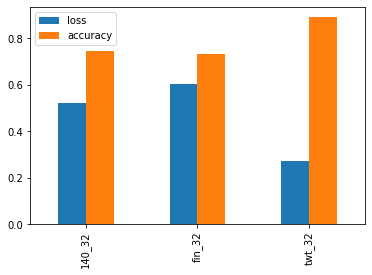

In [65]:
compare_df.plot(kind="bar") 

In [66]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def score(y_true, y_preds):
    """
    Calculating Accuracy, Recall, Precision and F1 Score.
    """
    acc = accuracy_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds, average="weighted")
    precision = precision_score(y_true, y_preds, average="weighted")
    f1score = f1_score(y_true, y_preds, average="weighted")

    return {"acc":acc,
            "recall":recall,
            "precision":precision,
            "f1score":f1score}

In [67]:
# pick out labels and features from every dataset

y_true_140 = np.asarray(list(test_140_32.unbatch().map(lambda x,y:y)))
y_true_fin = np.asarray(list(test_fin_32.unbatch().map(lambda x,y:y)))
y_true_tw = np.asarray(list(test_tw_32.unbatch().map(lambda x,y:y)))


In [68]:
# Predictions

y_preds_140 = tf.math.round(best_140.predict(test_140_32))
y_preds_fin = (best_fin.predict(test_fin_32)).argmax(axis=1)
y_preds_tw =(best_twt.predict(test_tw_32)).argmax(axis=1)

In [69]:
#Score model
score_140 = score(y_true_140, y_preds_140)
score_fin = score(y_true_fin, y_preds_fin)
score_tw = score(y_true_tw, y_preds_tw)



In [70]:
score_df = pd.DataFrame([score_140,score_fin,score_tw], index=[best_140.name, best_fin.name, best_twt.name])
score_df

,acc,recall,precision,f1score
140_32,0.745313,0.745313,0.745589,0.745143
fin_32,0.734021,0.734021,0.724400,0.723463
twt_32,0.891613,0.891613,0.891599,0.891554


### Comparison of the models

It appears that our models fits best to general twitter scraped data. But let's check how each of the models behave on a real data from twitter.

#4. Connect to the twitter and validate it on a real data.

First, we'll connect to the twitter API v2 with tweepy library.
Next, we'll build a function to download recent tweets from the given topic/keywords. 

Last step is to make inferences on those real data and print out them, along sentences.

In [71]:
!pip install -U tweepy

import tweepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 94 kB 2.6 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: tweepy
    Found existing installation: tweepy 3.10.0
    Uninstalling tweepy-3.10.0:
      Successfully uninstalled tweepy-3.10.0


In [72]:
!pip install python-dotenv
import dotenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
dotenv.load_dotenv('/content/gdrive/MyDrive/CREDENTIALS/t.env') # upload .env file with bearer token from twitter developers account

True

In [74]:
client = tweepy.Client(bearer_token=os.environ["BEARER_TOKEN"]) # initialize the class 

In [75]:

def tweets_to_dataframe(topic: str, max_results=10):
    """
    Calls twitter api, and split response into a dataframe for prediction.

    """

    response = client.search_recent_tweets(topic, max_results=max_results)
    tweets = response.data
    ids = [tweet.id for tweet in tweets]
    tweet = [tweet.text for tweet in tweets]

    return pd.DataFrame([ids, tweet], index=["index","tweet"]).T

In [76]:
tweets_to_dataframe("Elon Musk lang:en", 10).head(3) # test if this works, lang:en is a query from twitter api documentation for filtering specific language

,index,tweet
0,1579416372622557185,RT @sillyhead: my cantankerous jewish opinion:...
1,1579416369615245312,RT @w_terrence: Zelenskyy is still mad at Elon...
2,1579416357208461312,RT @VABVOX: Am I the only person on Twitter wh...


In [77]:
# get databases for predictions. Now we have to labels all those tweets, to compare how well our model predicted.

elon_tweets = tweets_to_dataframe("Elon Musk lang:en", 100)
elon_tweets.tweet.to_numpy()[:10] # print out tweets

array(['RT @sillyhead: my cantankerous jewish opinion: elon musk would rather more people blame secret jewish power (does not exist) rather than un…',
       'RT @w_terrence: Zelenskyy is still mad at Elon Musk for suggesting Peace so lives can be saved and to prevent WW3. Zelenskyy don’t want pea…',
       "RT @VABVOX: Am I the only person on Twitter who doesn't follow Elon Musk?",
       'RT @SaeedDiCaprio: elon musk should stop worrying about space x and start worrying about the eXtra SPACE between his forehead and hairline',
       'RT @MattWallace888: Elon Musk will be the first trillionaire',
       'RT @RhonddaBryant: Elon Musk is wrong on Ukraine and Taiwan. The arrogance of the supremely wealthy who would barter with other people’s fr…',
       'RT @SaeedDiCaprio: elon musk wanted this tweet gone soooo bad https://t.co/31rRgKk2qP',
       "RT @realDonJTru: Thank you Elon Musk, I'm Back!!",
       "RT @realDonJTru: Thank you Elon Musk, I'm Back!!",
       '@onefussyone Yes the 

In [78]:
bitcoin_tweets = tweets_to_dataframe("Bitcoin lang:en", 100)

bitcoin_tweets.tweet.to_numpy()[:10]

array(['RT @icsmen: Anyone else using the same background wallpaper ? 😁\n\n@binance @Indoex_LTD @MetaMask @TrustWallet \n\n@Meta\n\n$MGLD ⚡\n\n#btc #bitcoi…',
       'RT @BitcoinFear: Bitcoin Fear and Greed Index is 22 — Extreme Fear\nCurrent price: $19,413 https://t.co/9SB3dyTz5K',
       '@bitrabbit_btc @fmdroid @muneeb @markymark 💎The next Moonshot right here! 💎\nhttps://t.co/1U1EewC70C\n\n🌐 https://t.co/CaPyxvgs3Z\n@RoboSquidToken\n\n #RoboSquidToken \n#Binance #BNB #BTC\n#Bitcoin #ETH #SHIB #dogecoin #doge #ElonMusk #Crypto #altcoin #SquidGame #SquidGrowArmy #SquidGrow #BabyDogeSwap #Babydoge',
       'RT @RoboSquidToken: 🐙🔥 #PRESALE &amp; #LAUNCH TODAY 4PM UTC! 🚀🐙\n\n#RoboSquidToken \n#BSC #BNB #BinanceSmartChain #BTC #Bitcoin #altcoin #ETH #XRP…',
       'RT @DegenPunters: Are you Degen enough to be a Punter??🎰\n@Stake @rollbitcom @Roobet @Duelbits \n.\n.\n\n#nft #crypto #nftcommunity #nftcollecto…',
       "@StandardKenya For all those who are new to this working from home Bitc

In [79]:
football_tweets = tweets_to_dataframe("soccer lang:en", 100)

football_tweets.tweet.to_numpy()[:10]

array(['RT @RachealAine: I’m not into soccer naye I have to confess that from today Arsenal will always be my team💃💃❤️\nHello Arsenal Fam✋',
       "RT @USC_WSoccer: Here's your USC #StartingXI for the Trojans' Senior Day matchup with Arizona State. Less than 15 minutes from kickoff at M…",
       'Zambian soccer star Mwepu retires at 24 after\xa0being diagnosed with a hereditary heart\xa0issue https://t.co/8aFburPD4X',
       '@Tarak94158555 @RonFilipkowski I live a mile away and the kids soccer games next door had more people. You ever look at house websites and they make the rooms look bigger then they are...same thing here, this was definitely one of his smaller crowds which is why he avoids cities and sticks to rural areas.',
       "@Imhotep2021 @Ngoako17 @iDiskiTimes We didn't others did,the person who posted this is a soccer journalist not a chiefs journalist \nI never and will never say Sha is not a good player he is great but because others have their reasons to compare don't

### Predictions for each of the datasets

In [80]:
elon_preds = best_twt.predict(elon_tweets.tweet.to_numpy()).argmax(axis=1)
btc_preds = best_twt.predict(bitcoin_tweets.tweet.to_numpy()).argmax(axis=1)
football_preds = best_twt.predict(football_tweets.tweet.to_numpy()).argmax(axis=1)


In [81]:
# add predictions to the dataframes
elon_tweets["predicted_sentiment"] = elon_preds
bitcoin_tweets["predicted_sentiment"] = btc_preds
football_tweets["predicted_sentiment"] = football_preds

In [82]:
# concatanate dataframe
all_tweets = pd.concat([elon_tweets, bitcoin_tweets, football_tweets])

In [83]:
# and we want to make it more readable for human
dict_mapper = {0:"negative",
               1:"neutral",
               2:"positive"}

In [84]:
all_tweets.predicted_sentiment = all_tweets.predicted_sentiment.map(dict_mapper)

### Final results - how well model performed on a real input.  
Everyone can evaluate those results by themselves :)

In [85]:
# Below you can check predictions vs real results for all tweets :)
all_tweets[["tweet", "predicted_sentiment"]].to_numpy()[:10]

array([['RT @sillyhead: my cantankerous jewish opinion: elon musk would rather more people blame secret jewish power (does not exist) rather than un…',
        'negative'],
       ['RT @w_terrence: Zelenskyy is still mad at Elon Musk for suggesting Peace so lives can be saved and to prevent WW3. Zelenskyy don’t want pea…',
        'positive'],
       ["RT @VABVOX: Am I the only person on Twitter who doesn't follow Elon Musk?",
        'negative'],
       ['RT @SaeedDiCaprio: elon musk should stop worrying about space x and start worrying about the eXtra SPACE between his forehead and hairline',
        'negative'],
       ['RT @MattWallace888: Elon Musk will be the first trillionaire',
        'positive'],
       ['RT @RhonddaBryant: Elon Musk is wrong on Ukraine and Taiwan. The arrogance of the supremely wealthy who would barter with other people’s fr…',
        'neutral'],
       ['RT @SaeedDiCaprio: elon musk wanted this tweet gone soooo bad https://t.co/31rRgKk2qP',
        'positi

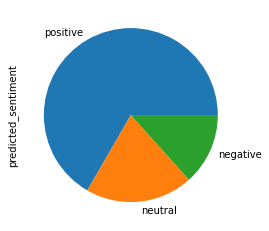

In [86]:
# Let's plot what is the distribution
all_tweets.predicted_sentiment.value_counts().plot(kind="pie")

In [87]:
#And take out and print some samples per each category
negatives = all_tweets[all_tweets.predicted_sentiment == "negative"].sample(frac=0.25).to_numpy(); negatives

array([[1579415198221602818,
        'Pool Results for 2022-03-08 Soccer 4 - Tue S4 - P1 Tips: X, X, 2, 1',
        'negative'],
       [1579416043189305349,
        "RT @GulfKanawutEC: ⚽️: just cause (i) have so many people cheering/supporting me (soccer play) doesn't mean i can/will play well 😂\n\n// so h…",
        'negative'],
       [1579416076206878720,
        '@AsmilaJ @realDonJTru Or to think Elon is actually THAT stupid! sir LIESaLot would NEVER thank him! He’d be declaring how IF it wasn’t FOR him, Elon would NOT been able to buy Twitter! It would be ONLY about dr. LIEsol the malignant narcissist DICtator wannabe! Musk would NOT bow to a degenerate loser',
        'negative'],
       [1579416062835425280,
        "RT @VABVOX: Am I the only person on Twitter who doesn't follow Elon Musk?",
        'negative'],
       [1579416195392233472,
        '@XoliswaZondo You r clowning now...soccer is not for u',
        'negative'],
       [1579415213006520320,
        'Pool Results f

In [88]:
positives = all_tweets[all_tweets.predicted_sentiment == "positive"].sample(frac=0.05).to_numpy(); positives

array([[1579416100353478659,
        'RT @CelebrityRamp: Heung Min Son: Net Worth, Height, Age, Biography &amp; More\n#HeungMinSon #FIFA #Facts  #networth #biography #football #socce…',
        'positive'],
       [1579416204036681728,
        "RT @realDonJTru: Thank you Elon Musk, I'm Back!!", 'positive'],
       [1579415978047594497,
        "RT @realDonJTru: Thank you Elon Musk, I'm Back!!", 'positive'],
       [1579416286849011713,
        '@VernaSenior 💎The next Moonshot right here! 💎\nhttps://t.co/1U1EewC70C\n\n🌐 https://t.co/CaPyxvgs3Z\n@RoboSquidToken\n\n #RoboSquidToken \n#Binance #BNB #BTC\n#Bitcoin #ETH #SHIB #dogecoin #doge #ElonMusk #Crypto #altcoin #SquidGame #SquidGrowArmy #SquidGrow #BabyDogeSwap #Babydoge',
        'positive'],
       [1579416338338295808,
        'RT @montymetzger: 🔥 $1000 GIVEAWAY!!! 🔥\n\nIn order to celebrate @LCX revamp, I’ll be giving away $1000 in $LCX $ETH $BTC or $QNT\n\n🏓 To enter…',
        'positive'],
       [1579415857591386113,
        'R

# Final Thoughts

We have to be very curious when using those kind of NLP classificator while scoring some fragile cases, because higher values in the metrcis means only hoe well those models are fitting pre-labeled data. And therefor, those pre-labeling maybe somehow biased. 